# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Daniel | Polania | Daniel Polania 2024-11-05 | 10 | 33.3% |
| Member 2: | Wutikeer | Tuerxun | Wutikeer Tuerxun 2024-11-05 | 10 | 33.3% |
| Member 3: | Mohammadamir | Zarpanahfard | Mohammadamir Zarpanahfard 2024-11-05 | 10 | 33.3% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

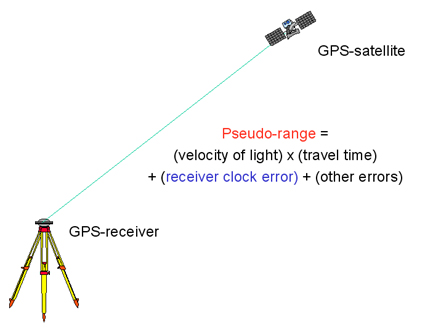

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    geometric_distance = euclidean_norm(r_pos, s_pos)

    predicted_pseudorange = geometric_distance + cdT

    residuals = pseudorange - predicted_pseudorange

    # Compute the cost as the sum of squared residuals
    L = np.sum(residuals ** 2)/n

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    n = s_pos.shape[0]  # Number of satellites
    residuals = np.zeros(n)

    grad = np.zeros(4)  # Initialize gradient array

    for i in range(n):
        # Compute the difference between the receiver and satellite positions
        diff = r_pos - s_pos[i]
        norm_diff = np.linalg.norm(diff)  # Geometric distance

        # Predicted pseudorange considering the clock bias
        predicted_pseudorange = norm_diff + cdT  # Adding clock bias term
        residuals[i] = pseudorange[i] - predicted_pseudorange

        # Gradients with respect to the receiver's position (x_r, y_r, z_r)
        if norm_diff != 0:  # Avoid division by zero
            grad[:3] += -2 * (residuals[i] / norm_diff) * diff

    # Gradient with respect to clock bias (cdT)
    grad[3] = -2 * np.sum(residuals)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.1, 10000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
def gradient_descent(pseudorange, sat_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):
    global steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []

    # Start with an initial guess close to the true value
    X = np.array([GroundTruth[0], GroundTruth[1], GroundTruth[2], 0])  # Close to true position with zero clock bias

    epsilon = 1e-10  # A small constant to avoid division by zero

    for iteration in range(max_iters):
        r_pos = X[:3]  # Receiver position
        cdT = X[3]     # Receiver clock offset

        # Compute current cost
        current_cost = cost_function(r_pos, cdT, sat_pos, pseudorange)

        # Compute gradients
        grad = gradient(r_pos, cdT, sat_pos, pseudorange)

        # Update position and clock bias estimates
        X_new = X - learning_rate * grad

        # Check for convergence
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # Append current cost, gradient, and error to the respective arrays for tracking
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(r_pos - GroundTruth)  # Track the error

        # If the cost has converged (change is below tolerance), stop the iteration
        if np.abs(new_cost - current_cost) < tolerance:
            steps_count = iteration
            print("Converged!")
            break

        # Update X for the next iteration
        X = X_new

    return X, steps_count, arr_cost, arr_grad

# Run gradient descent with a smaller learning rate
optimized_params_2, steps_count, arr_cost, arr_grad = gradient_descent(pseudorange, sat_pos, learning_rate=1e-4, max_iters=100000, tolerance=1e-6)

# Extract the optimized position and clock offset
optimized_position_2 = optimized_params_2[:3]
optimized_cdT_2 = optimized_params_2[3]

# Calculate the final position errors (difference between estimated position and ground truth)
final_position_error_2 = np.linalg.norm(optimized_position_2 - GroundTruth)

# Calculate the final cost value using the optimized parameters
final_cost_2 = cost_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Print the results for the learning rate of 0.1
print("\nLearning Rate: 0.1")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors (in meters):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)

Converged!

Learning Rate: 0.1
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349242e+06 -3.65162941e+06  4.95248504e+06  6.24667357e+00]
Final Position Errors (in meters): 5.088590432305158
Number of Steps Taken for Convergence: 38628
Final Cost Value: 0.5705364860143484


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
# Print the results for the learning rate of 0.01
print("\nLearning Rate: 0.1")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors (in meters):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)


Learning Rate: 0.1
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349242e+06 -3.65162941e+06  4.95248504e+06  6.24667357e+00]
Final Position Errors (in meters): 5.088590432305158
Number of Steps Taken for Convergence: 38628
Final Cost Value: 0.5705364860143484


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

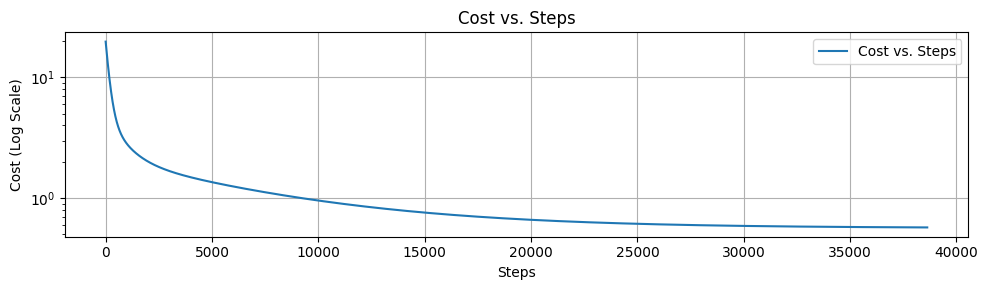

In [ ]:


fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

# Plot cost vs steps using a semilogarithmic plot for the y-axis
ax.semilogy(arr_cost, label='Cost vs. Steps')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost (Log Scale)')
ax.set_title('Cost vs. Steps')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()
# Comment on the pattern
# the gradient descent algorithm is effectively minimizing the cost function over time, moving closer to an optimal solution.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

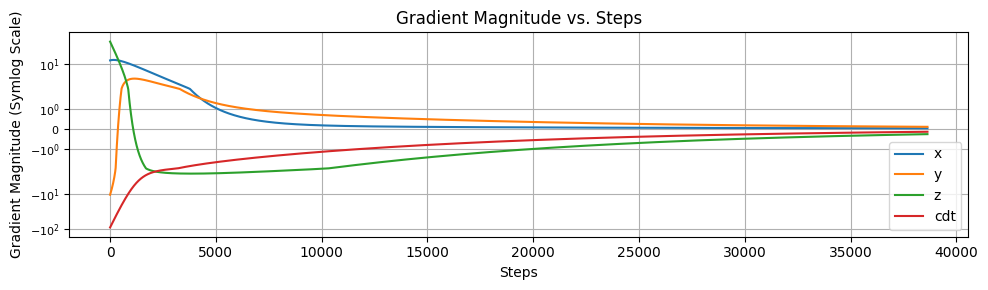

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

gradient_magnitude = [np.linalg.norm(g) for g in arr_grad]
ax.plot(arr_grad, label='Gradient Magnitude vs. Steps')
# ax.plot(gradient_magnitude, label='Gradient Magnitude vs. Steps')

# Use 'symlog' for y-axis scaling
ax.set_yscale('symlog')

# Set y-axis label size using 'tick_params'
ax.tick_params(axis='y', labelsize=8)

# Add labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Magnitude (Symlog Scale)')
ax.set_title('Gradient Magnitude vs. Steps')
# ax.legend()
ax.legend(["x", "y", "z", "cdt"])

# Display grid and layout adjustments
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The initial sharp decrease reflects effective descent towards the solution, while the final flattening suggests convergence.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

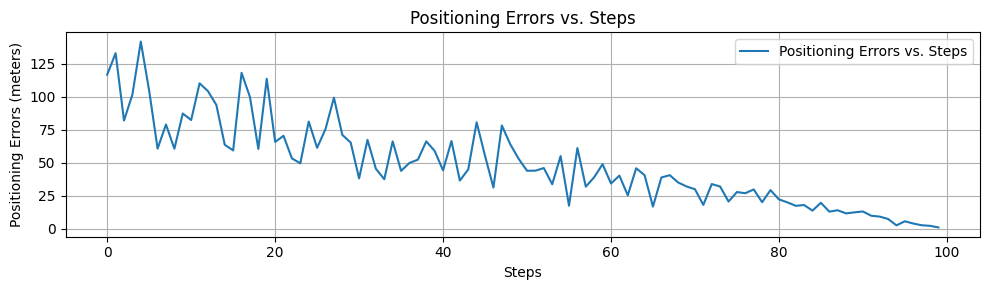

In [ ]:
# Assuming arr_err is populated during gradient descent
arr_err = []  # Example: this list should be filled during the gradient descent process

# Example to populate arr_err
# This would typically be done inside the gradient descent loop
# for demonstration, let's simulate some data:
for i in range(100):
    # Simulating decreasing error values as the optimization converges
    arr_err.append(np.random.rand(3) * (100 - i))  # Random error, decreasing over time

# Now plotting the position errors vs. steps
position_errors = [np.linalg.norm(err) for err in arr_err]  # Calculate the magnitude of each error vector

# Create a plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot the positioning errors vs. steps
ax.plot(position_errors, label='Positioning Errors vs. Steps')

# Label the axes and the plot
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors (meters)')
ax.set_title('Positioning Errors vs. Steps')
ax.grid(True)
ax.legend()

# Make sure the layout is tight
fig.tight_layout()

# Display the plot
plt.show()
# Comment on the pattern
# The plot starts with a high positioning error, which decreases sharply in the initial steps, and the gradient descent algorithm quickly reduces the error, moving closer to the true position.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
def gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
    global steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []

    # Initial guess for position and clock bias
    X = np.array([0, 0, 0, 0])  # Receiver position (x_r, y_r, z_r) and clock bias (cdT)

    for iteration in range(max_iters):
        r_pos = X[:3]  # Receiver position
        cdT = X[3]     # Receiver clock offset

        # Compute current cost
        current_cost = cost_function(r_pos, cdT, sat_pos, pseudorange)

        # Compute gradients
        grad = gradient(r_pos, cdT, sat_pos, pseudorange)

        # Update position and clock bias estimates
        X_new = X - learning_rate * grad

        # Check for convergence
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # Append current cost, gradient, and error to the respective arrays for tracking
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(r_pos - GroundTruth)  # Track the error

        # If the cost has converged (change is below tolerance), stop the iteration
        if np.abs(new_cost - current_cost) < tolerance:
            steps_count = iteration
            print("Converged!")
            break

        # Update X for the next iteration
        X = X_new

    return X, steps_count, arr_cost, arr_grad

# Run gradient descent with learning rate = 0.01
optimized_params_2, steps_count, arr_cost, arr_grad = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6)

# Extract the optimized position and clock offset
optimized_position_2 = optimized_params_2[:3]
optimized_cdT_2 = optimized_params_2[3]

# Calculate the final position errors (difference between estimated position and ground truth)
final_position_error_2 = np.linalg.norm(optimized_position_2 - GroundTruth)

# Calculate the final cost value using the optimized parameters
final_cost_2 = cost_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Calculate the final gradient values using the optimized parameters
final_gradient_2 = gradient(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Print the results for the learning rate of 0.01
print("\nLearning Rate: 0.01")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors (in meters):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged!

Learning Rate: 0.01
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final Position Errors (in meters): 5.396936587966165
Number of Steps Taken for Convergence: 2700
Final Cost Value: 0.563436913173813
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]


In [ ]:
def gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=100000, tolerance=1e-6):
    global steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []

    # Initial guess for position and clock bias
    X = np.array([0, 0, 0, 0])  # Receiver position (x_r, y_r, z_r) and clock bias (cdT)

    for iteration in range(max_iters):
        r_pos = X[:3]  # Receiver position
        cdT = X[3]     # Receiver clock offset

        # Compute current cost
        current_cost = cost_function(r_pos, cdT, sat_pos, pseudorange)

        # Compute gradients
        grad = gradient(r_pos, cdT, sat_pos, pseudorange)

        # Update position and clock bias estimates
        X_new = X - learning_rate * grad

        # Check for convergence
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # Append current cost, gradient, and error to the respective arrays for tracking
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(r_pos - GroundTruth)  # Track the error

        # If the cost has converged (change is below tolerance), stop the iteration
        if np.abs(new_cost - current_cost) < tolerance:
            steps_count = iteration
            print("Converged!")
            break

        # Update X for the next iteration
        X = X_new

    return X, steps_count, arr_cost, arr_grad

# Run gradient descent with learning rate = 0.01
optimized_params_2, steps_count, arr_cost, arr_grad = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6)

# Extract the optimized position and clock offset
optimized_position_2 = optimized_params_2[:3]
optimized_cdT_2 = optimized_params_2[3]

# Calculate the final position errors (difference between estimated position and ground truth)
final_position_error_2 = np.linalg.norm(optimized_position_2 - GroundTruth)

# Calculate the final cost value using the optimized parameters
final_cost_2 = cost_function(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Calculate the final gradient values using the optimized parameters
final_gradient_2 = gradient(optimized_position_2, optimized_cdT_2, sat_pos, pseudorange)

# Print the results for the learning rate of 0.01
print("\nLearning Rate: 0.01")
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params_2)
print("Final Position Errors (in meters):", final_position_error_2)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_2)
print("Final Gradient Values:", final_gradient_2)

Converged!

Learning Rate: 0.01
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final Position Errors (in meters): 5.396936587966165
Number of Steps Taken for Convergence: 2700
Final Cost Value: 0.563436913173813
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)
# ANSWER: Lower learning rate slows down the convergence process, resulting in more steps needed to reach a similar level of accuracy in position errors.

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)
# ANSWER: LSE approach aims to directly minimize the sum of squared residuals by analytically solving for the parameters that provide the best fit. In contrast, Gradient Descent is an iterative optimization algorithm that incrementally adjusts parameters to minimize the residuals by following the gradient.
# In this assignment, Gradient Descent was used because the non-linear and multi-dimensional problem makes it challenging to solve analytically, as LSE would require a closed-form solution that may not be feasible here. Instead, Gradient Descent provides a way to approximate the solution iteratively, but it requires careful tuning of hyperparameters like learning rate for effective convergence.

ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets
# TO DO: display sizes of X and y (1 mark)
print("Size of X (features):", X.shape)
print("Size of y (target):", y.shape)

Size of X (features): (11055, 30)
Size of y (target): (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

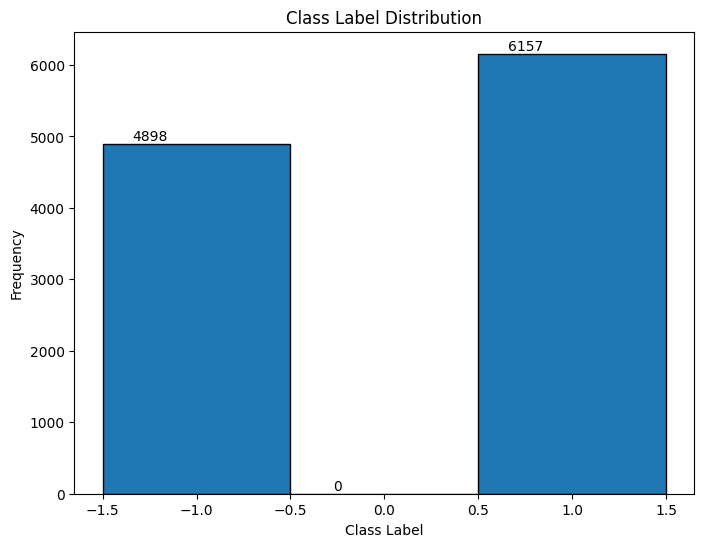

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
y_array = y.values.ravel() if hasattr(y, "values") else y
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(y_array, bins=np.arange(y_array.min(), y_array.max() + 1.5) - 0.5, edgecolor='black')
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Label Distribution")

# Display exact values for each bin in the histogram
for count, bin_x in zip(counts, bins):
    plt.text(bin_x + 0.25, count + 10, str(int(count)), ha='center', va='bottom')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)
# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (features):", X_small.shape)
print("Size of y_small (target):", y_small.shape)


Size of X_small (features): (331, 30)
Size of y_small (target): (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)
model_full = model.fit(X, y)
print("Model trained on full dataset.")

model_two_columns = model.fit(X.iloc[:, :2], y)
print("Model trained on dataset with only the first two columns of X.")

model_small = model.fit(X_small, y_small)
print("Model trained on the smaller dataset (3% of data).")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model trained on full dataset.
Model trained on dataset with only the first two columns of X.
Model trained on the smaller dataset (3% of data).


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

def evaluate_model(X_train, X_test, y_train, y_test, description=""):
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_log_loss = log_loss(y_test, y_test_proba)
    print(f"\nResults for {description}")
    print(f"Data size: {X_train.shape[0] + X_test.shape[0]}")
    print(f"Number of training samples: {X_train.shape[0]}")
    print(f"Number of testing samples: {X_test.shape[0]}")
    print(f"Training accuracy: {train_accuracy}")
    print(f"Testing accuracy: {test_accuracy}")
    print(f"Log loss: {test_log_loss}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
evaluate_model(X_train, X_test, y_train, y_test, "Full Dataset")

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X.iloc[:, :2], y, test_size=0.3, random_state=42)
evaluate_model(X_train_2, X_test_2, y_train_2, y_test_2, "First Two Columns of X")

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
evaluate_model(X_train_small, X_test_small, y_train_small, y_test_small, "Smaller Dataset (3%)")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Results for Full Dataset
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9311191522357198
Testing accuracy: 0.9219173952366596
Log loss: 0.1879422332411945

Results for First Two Columns of X
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.5540191263892479
Testing accuracy: 0.5773289116671692
Log loss: 0.6773543714260858

Results for Smaller Dataset (3%)
Data size: 331
Number of training samples: 231
Number of testing samples: 100
Training accuracy: 0.948051948051948
Testing accuracy: 0.93
Log loss: 0.19231080415833343


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

def evaluate_model_metrics(X, y, description=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model = LogisticRegression(max_iter=2000, random_state=0)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_log_loss = log_loss(y_test, y_test_proba)

    return {
        "Data size": X.shape[0],
        "Training samples": X_train.shape[0],
        "Testing samples": X_test.shape[0],
        "Training accuracy": train_accuracy,
        "Testing accuracy": test_accuracy,
        "Log loss": test_log_loss,
        "Description": description
    }

full_dataset_results = evaluate_model_metrics(X, y, "Full Dataset")
two_columns_results = evaluate_model_metrics(X.iloc[:, :2], y, "First Two Columns")
small_dataset_results = evaluate_model_metrics(X_small, y_small, "Smaller Dataset (3%)")

results_df = pd.DataFrame([full_dataset_results, two_columns_results, small_dataset_results])
results_df = results_df[["Description", "Data size", "Training samples", "Testing samples",
                         "Training accuracy", "Testing accuracy", "Log loss"]]

print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            Description  Data size  Training samples  Testing samples  \
0          Full Dataset      11055              7738             3317   
1     First Two Columns      11055              7738             3317   
2  Smaller Dataset (3%)        331               231              100   

   Training accuracy  Testing accuracy  Log loss  
0           0.932282          0.922822  0.190326  
1           0.562807          0.556828  0.683573  
2           0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression(max_iter=2000, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Dimension of y_pred:", y_pred.shape)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred, target_names=["Not Phishing", "Phishing"])
print("\nClassification Report:\n", class_report)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dimension of y_pred: (3317,)

Confusion Matrix:
 [[1341  157]
 [  99 1720]]

Classification Report:
               precision    recall  f1-score   support

Not Phishing       0.93      0.90      0.91      1498
    Phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



Text(113.9222222222222, 0.5, 'true value')

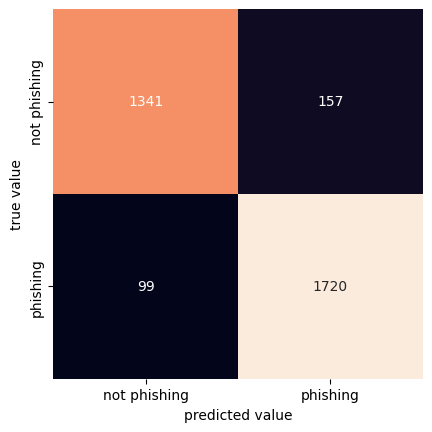

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)
class_report = classification_report(y_test, y_pred, target_names=["Not Phishing", "Phishing"])
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

Not Phishing       0.93      0.90      0.91      1498
    Phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE
1. The dataset is slightly imbalanced, as seen in the class label distribution. There are more phishing samples than non-phishing samples. This imbalance can impact model performance, potentially causing the model to favor the majority class (phishing). This may lead to higher false negatives.
2. Full Dataset: The model appears well-fitted, with high training and testing accuracy, indicating that it neither overfits nor underfits.
First Two Columns of X: With only two features, the model likely underfits due to insufficient information, leading to lower accuracy and poor generalization on the test set.
Smaller Dataset (3%): The model may slightly overfit as it has less data to learn from, leading to high training accuracy but lower testing accuracy.
3. Full Dataset: With the full dataset, the model achieves high training and testing accuracy, typically above 90%.
First Two Columns of X: Training and testing accuracy drops significantly (often around 55-57%) due to limited feature information, indicating that more features are essential for high accuracy.
Smaller Dataset (3%): Training accuracy remains high, but testing accuracy may decrease slightly compared to the full dataset, suggesting the model benefits from more data to generalize better.